# 1. Dependencies

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
import numpy as np
from scipy.interpolate import griddata

# Coffee Cup example

# 2. Newton's Law of Cooling and Euler's Method

Newton's Law of Cooling describes how the temperature of an object changes over time as it exchanges heat with its environment. The differential equation is:

$$
\frac{dT}{dt} = -k(T - T_{\text{env}})
$$

where:  
- $T(t)$ is the temperature of the object at time $t$,  
- $T_{\text{env}}$ is the constant ambient temperature,  
- $k > 0$ is a constant that depends on the characteristics of the object and environment.

We can approximate the solution using **Euler's method**. Given an initial temperature $T_0$ at time $t = 0$, and a time step $\Delta t$, the recursive update rule is:

$$
T_{n+1} = T_n + \Delta t \cdot \left( -k(T_n - T_{\text{env}}) \right)
$$

This lets us step forward in time, estimating the temperature at each point. The smaller the step size $\Delta t$, the more accurate the approximation becomes.


In [3]:
T_env = 90
T_0 = 150
r = .5

def T(t):
    return (T_0 - T_env)*np.exp(-r*t) + T_env

time_space = np.linspace(start=0, stop=10, num=1000)
t_given = time_space[:100]
T_true = np.array([T(t) for t in time_space])
T_given = np.array([T(t) for t in t_given])

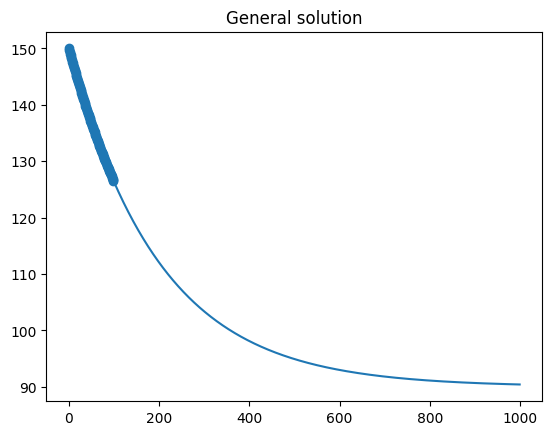

In [4]:
plt.plot(T_true)
plt.title("General solution")
plt.scatter(x=[t_given*100], y=T_given, marker='o')

# 3. Introducing a Physics Informed Neural Network

To approximate the solution to Newton's Law of Cooling using a Physics-Informed Neural Network, we define a neural network $\ \hat{T}(t; \theta) \ $ that takes time $ t $ as input and outputs a temperature prediction. The network is trained not only to fit data, but also to satisfy the governing differential equation.

Recall the equation:

$$
\frac{dT}{dt} = -k(T - T_{\text{env}})
$$

The PINN is trained using a loss function that penalizes deviations from both the differential equation and any known initial or boundary conditions. Specifically, the total loss is typically a weighted sum of:

1. **Physics loss (residual):**
   We enforce the differential equation by computing the derivative  $ \frac{d\hat{T}}{dt} $ . Using automatic differentiation, and minimizing the residual:

   $$
   \mathcal{L}_{\text{physics}} = \frac{1}{N_f} \sum_{i=1}^{N_f} \left( \frac{d\hat{T}}{dt}(t_i) + k(\hat{T}(t_i) - T_{\text{env}}) \right)^2
   $$

2. **Initial condition loss:**
   We incorporate known initial data, for example \( T(0) = T_0 \), via:

   $$
   \mathcal{L}_{\text{IC}} = \left( \hat{T}(0) - T_0 \right)^2
   $$

The total loss becomes:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{physics}} + \mathcal{L}_{\text{IC}}
$$

By minimizing this loss, the neural network learns a function $ \hat{T}(t) \ $ that closely matches the behavior dictated by Newton's Law of Cooling, without requiring an explicit solution of the ODE.

This method generalizes well to more complex systems where traditional numerical methods are difficult to apply or where data is sparse.


In [5]:
class PINNLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0]
    
    def physical_loss(self, model, ts):
        ts = ts.clone().detach().requires_grad_(True)
        inputs = ts
        outputs = model(ts)
        df_dt = self.grad(outputs=outputs, inputs=inputs)
        loss_term = df_dt - r*(T_env - outputs)
        return torch.mean(loss_term**2)
    
    def forward(self, model, ts, t_given, T_given):
        loss = torch.mean((model(t_given)[0] - T_0)**2) + self.physical_loss(model, ts)
        return loss

In [6]:
targets = T_given

model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

criterion = PINNLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(torch.tensor(t_given).float().reshape(100,1))
    loss = criterion(model=model,
                     ts=torch.tensor(time_space).float().reshape(1000,1),
                     t_given=torch.tensor(t_given).float().reshape(100,1),
                     T_given=T_given)
    loss.backward()
    optimizer.step()

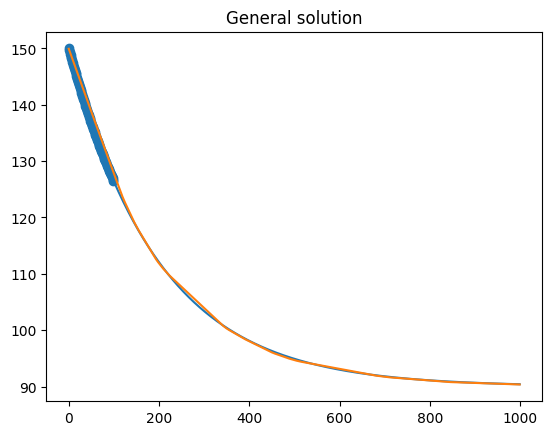

In [7]:
plt.plot(T_true)
plt.title("General solution")
plt.scatter(x=[t_given*100], y=T_given, marker='o')
plt.plot(model(torch.tensor(time_space).float().reshape(1000,1)).detach().numpy())

# 4. 1-D Heat Equation

### The 1D Heat Equation and the Method of Lines

The one-dimensional heat equation models how heat diffuses along a rod over time. The PDE is given by:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

where:
- $\ u(x, t) \ $ is the temperature at position \$ x \$ and time \$ t \$,
- $\alpha > 0 $ is the thermal diffusivity constant.

To solve this equation numerically using the **Method of Lines (MOL)**, we discretize the spatial domain while keeping time continuous. This converts the PDE into a system of ODEs that can be integrated using standard ODE solvers.

#### Step 1: Spatial Discretization

We divide the spatial domain $ [0, L] $ into $ N $ equally spaced points with spacing $ \Delta x \ $, and approximate the second derivative using finite differences:

$$
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1}(t) - 2u_i(t) + u_{i-1}(t)}{(\Delta x)^2}
$$

This yields a system of ODEs:

$$
\frac{d u_i}{dt} = \alpha \cdot \frac{u_{i+1}(t) - 2u_i(t) + u_{i-1}(t)}{(\Delta x)^2}
$$

for $ i = 1, 2, \dots, N-1 $, where $ u_0(t) $ and $u_N(t)$  are set by boundary conditions.

#### Step 2: Time Integration

The resulting system can now be solved using an ODE solver such as Euler's method or Runge-Kutta:

$$
u_i^{n+1} = u_i^n + \Delta t \cdot \left[ \alpha \cdot \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{(\Delta x)^2} \right]
$$


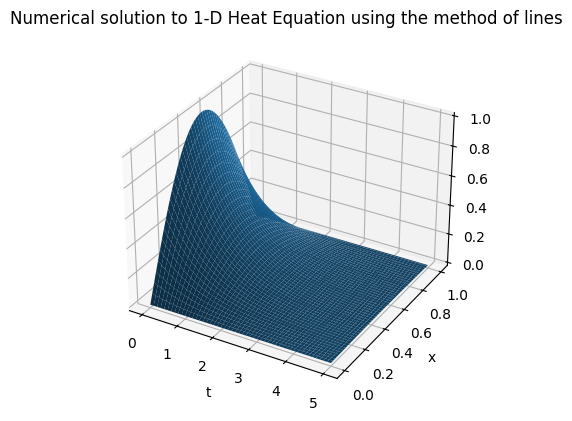

In [8]:
def IC(x):
    return np.sin(np.pi*x)

u_0 = u_L = 0
time_mesh = np.linspace(start=0, stop=5, num=10000)
spatial_mesh = np.linspace(start=0, stop=1, num=100)
ic = np.array([IC(x) for x in spatial_mesh])
k = .5

u = np.zeros((100,10000))
u[:,0] = ic
u[0,:] = u_0
u[-1,:] = u_L

for n in range(0, len(time_mesh) - 1):
    for j in range(1, len(spatial_mesh) - 1):
        u[j, n+1] = u[j, n] + k * (u[j+1, n] - 2*u[j, n] + u[j-1,n])

X, Y = np.meshgrid(spatial_mesh, time_mesh)  # shape = (10000, 1000)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Y, X, u.T)
plt.xlabel('t')
plt.ylabel('x')
plt.title("Numerical solution to 1-D Heat Equation using the method of lines")
plt.show()

# 5. Solving the 1D Heat Equation with a PINN

The 1D heat equation is a classic partial differential equation that models the diffusion of heat along a rod:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

To approximate the solution using a Physics-Informed Neural Network (PINN), we define a neural network $ \hat{u}(x, t; \theta) $ that takes spatial and temporal coordinates as inputs and outputs a scalar temperature. This network is trained to satisfy the PDE at collocation points in space-time, along with the initial and boundary conditions.

#### Physics Loss (PDE Residual)

Using automatic differentiation, we compute the derivatives of the network output and enforce the PDE by minimizing the residual:

$$
\mathcal{L}_{\text{physics}} = \frac{1}{N_f} \sum_{i=1}^{N_f} \left( \frac{\partial \hat{u}}{\partial t}(x_i, t_i) - \alpha \frac{\partial^2 \hat{u}}{\partial x^2}(x_i, t_i) \right)^2
$$

#### Initial and Boundary Conditions

We also enforce known initial and boundary values. For example, for initial condition \( u(x, 0) = f(x) \) and Dirichlet boundaries \( u(0, t) = u(L, t) = 0 \), we define:

- **Initial loss**:

  $$
  \mathcal{L}_{\text{IC}} = \frac{1}{N_0} \sum_{i=1}^{N_0} \left( \hat{u}(x_i, 0) - f(x_i) \right)^2
  $$

- **Boundary loss**:

  $$
  \mathcal{L}_{\text{BC}} = \frac{1}{N_b} \sum_{i=1}^{N_b} \left( \hat{u}(0, t_i)^2 + \hat{u}(L, t_i)^2 \right)
  $$

#### Total Loss

The total loss combines all components:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{physics}} + \mathcal{L}_{\text{IC}} + \mathcal{L}_{\text{BC}}
$$

Minimizing this loss trains the network to produce an approximate solution $ \hat{u}(x, t) \ $ that satisfies the PDE and all given conditions. This method scales well to high-dimensional or data-scarce problems.


7. Given problem

#### Initial Condition (IC)

$$
u(x, 0) = f(x)
$$

In this case, we are using:

$$
u(x, 0) = \sin(\pi x)
$$

This means that at time zero, the temperature distribution follows a sine wave profile along the rod from $ x = 0 $ to $ x = 1 $.

#### Boundary Conditions (BCs)

Boundary conditions describe how the solution behaves at the spatial boundaries for all times \( t > 0 \).

We are using **Dirichlet boundary conditions**, which fix the value of the solution at the endpoints of the spatial domain:

$$
u(0, t) = 0, \quad u(1, t) = 0
$$


In [282]:
# check that boundary and initial are defined on given domain
# physical loss should be defined on sampled collocation domain
# the 'collocation' for an ODE is just the temporal mesh, the given data loss can just be the initial condition
# the collocation for a PDE could be a space-time mesh, the given data loss is the spatial mesh evaluated at the initial condition, and the boundary condition are the endpoints evaluated across the temporal mesh

class PINN1DHeatLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def initial_condiition(self, x):
        return np.sin(np.pi*x)

    def du_dt_grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0][:,1]
    
    def d2u_dx2_grad(self, outputs, inputs):
        du_dx = torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0][:,0]

        d2u_dx2 = torch.autograd.grad(
            outputs=du_dx,
            inputs=inputs,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True, 
            retain_graph=True
        )[0][:,0]

        return d2u_dx2
    
    def physical_loss(self, model, ts, xs, mesh_points):
        inputs = torch.tensor(mesh_points, requires_grad=True).float()
        outputs = model(inputs)
        d2u_dx2 = self.d2u_dx2_grad(outputs=outputs, inputs=inputs)
        du_dt = self.du_dt_grad(outputs=outputs, inputs=inputs)
        loss_term = torch.mean((du_dt - d2u_dx2)**2)
        return loss_term
    
    def ic_loss(self, model, xs, ts):
        xs = torch.tensor(xs).float()
        ts = torch.tensor(np.array([0 for _ in range(len(xs))])).float()
        ic = torch.tensor(np.array([self.initial_condiition(x) for x in xs])).float()
        xt = torch.stack((xs, ts), dim=1)
        ic_pred = model(xt)
        return torch.mean((ic_pred - ic)**2)

    def bc_loss(self, model, ts): 
        xs_0 = torch.tensor(np.array([0 for _ in range(len(ts))])).float()
        xs_L = torch.tensor(np.array([1 for _ in range(len(ts))])).float()
        xt_0 = torch.stack([xs_0, torch.tensor(ts).float()], dim=1)
        xt_L = torch.stack([xs_L, torch.tensor(ts).float()], dim=1)
        bc_pred = torch.mean((model(xt_0)**2 + model(xt_L)**2))
        return bc_pred

    def forward(self, model, xs, ts, mesh_points):
        loss = .01*self.physical_loss(model=model, ts=ts, xs=xs, mesh_points=mesh_points) + self.ic_loss(model=model, xs=xs, ts=ts) + self.bc_loss(model=model, ts=ts)
        return loss

In [283]:
np.mean(np.array([1,2,3])**2 + np.array([4,5,6])**2)

30.333333333333332

In [284]:
np.mean(((np.array([1,2,3])) + np.mean(np.array([4,5,6])))**2)

49.666666666666664

In [285]:
new_lhs = lhs(2, samples=500)

xs = new_lhs[:,0]
ts = new_lhs[:,1]

pinn = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 1)
)

criterion = PINN1DHeatLoss()
optimizer = torch.optim.Adam(pinn.parameters(), lr=.01)

for epoch in range(3000):
    optimizer.zero_grad()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0)
    outputs = pinn(torch.tensor(new_lhs).float())
    loss = criterion(pinn, xs, ts, mesh_points=new_lhs)
    if epoch % 100 == 0:
        print(f"Loss at epoch {epoch}: {loss}")
    loss.backward()
    optimizer.step()

Loss at epoch 0: 0.4152849018573761
Loss at epoch 100: 0.12435354292392731
Loss at epoch 200: 0.11400613933801651
Loss at epoch 300: 0.1048751175403595
Loss at epoch 400: 0.10230223089456558
Loss at epoch 500: 0.10272709280252457
Loss at epoch 600: 0.10184544324874878
Loss at epoch 700: 0.0996251180768013
Loss at epoch 800: 0.09861768782138824
Loss at epoch 900: 0.09867957979440689
Loss at epoch 1000: 0.09831678122282028
Loss at epoch 1100: 0.1002672091126442
Loss at epoch 1200: 0.09743864089250565
Loss at epoch 1300: 0.0979325994849205
Loss at epoch 1400: 0.09751404821872711
Loss at epoch 1500: 0.0972333624958992
Loss at epoch 1600: 0.09754997491836548
Loss at epoch 1700: 0.09751537442207336
Loss at epoch 1800: 0.09998638182878494
Loss at epoch 1900: 0.09734750539064407
Loss at epoch 2000: 0.0996926948428154
Loss at epoch 2100: 0.09847619384527206
Loss at epoch 2200: 0.09685234725475311
Loss at epoch 2300: 0.09692370891571045
Loss at epoch 2400: 0.09914734959602356
Loss at epoch 2500:

In [286]:
min(outputs)

tensor([-0.0119], grad_fn=<UnbindBackward0>)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate fine mesh
xg = np.linspace(0, 1, 500)
tg = np.linspace(0, 1, 500)
X, T = np.meshgrid(xg, tg)

# Flatten and prepare for model input
XT = np.stack([X.flatten(), T.flatten()], axis=-1)
XT_tensor = torch.tensor(XT, dtype=torch.float32)

U_pred = model(XT_tensor).squeeze().cpu().numpy()

# Reshape to match grid
U = U_pred.reshape(X.shape)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='coolwarm', edgecolor='none')
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("u(x,t)")
plt.title("Numerical solution to 1-D heat, using PINN Loss")
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (250000x2 and 1x100)

# Thank you!